In [1]:
import os
import time
import matplotlib
import torch
import torchvision
from jedi.api.refactoring import inline
from torch import nn
from torch.utils.data import random_split
import torchvision.models as models
import torch.nn.functional as F

import mobilevit
import torch

from einops import rearrange
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torch.utils.data.distributed
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from sklearn.metrics import classification_report
from timm.data.mixup import Mixup
from timm.loss import SoftTargetCrossEntropy
from timm.models.mobilevit import mobilevit_s
from apex import amp
import warnings
import json
warnings.filterwarnings("ignore")
import time

In [ ]:
class ImageClassificationBase(nn.Module):
	def training_step(self, batch):
		images, labels = batch
		out = self(images)  # Generate predictions
		loss = F.cross_entropy(out, labels)  # Calculate loss
		return loss

	def validation_step(self, batch):
		images, labels = batch
		out = self(images)  # Generate predictions
		loss = F.cross_entropy(out, labels)  # Calculate loss
		acc = accuracy(out, labels)  # Calculate accuracy
		return {'val_loss': loss.detach(), 'val_acc': acc}

	def validation_epoch_end(self, outputs):
		batch_losses = [x['val_loss'] for x in outputs]
		epoch_loss = torch.stack(batch_losses).mean()  # Combine losses
		batch_accs = [x['val_acc'] for x in outputs]
		epoch_acc = torch.stack(batch_accs).mean()  # Combine accuracies
		return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

	def epoch_end(self, epoch, result):
		print("Epoch {}: train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
			epoch + 1, result['train_loss'], result['val_loss'], result['val_acc']))

In [3]:
data_dir = 'class/data'
classes = os.listdir(data_dir)
print(classes)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [4]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

In [5]:
import matplotlib.pyplot as plt


def show_sample(img, label,a):
    print("Label:", dataset.classes[label], "(Class No: " + str(label) + ")"+a)
    plt.imshow(img.permute(1, 2, 0))

Label: cardboard (Class No: 0)Usually
Label: cardboard (Class No: 0)Normalize


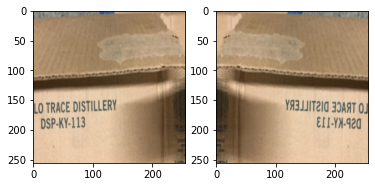

In [6]:
transformations = transforms.Compose([transforms.Resize((256, 256)),
                                      transforms.ToTensor()])
dataset = ImageFolder(data_dir, transform=transformations)
img, label = dataset[12]
plt.subplot(1,2,1)
a='Usually'
show_sample(img, label,a)
transformations = transforms.Compose([transforms.Resize((256, 256)),
                                      transforms.ToTensor(),
                                      transforms.RandomHorizontalFlip(0.5)
                                     ])
dataset = ImageFolder(data_dir, transform=transformations)
img, label = dataset[12]
plt.subplot(1,2,2)
a='Normalize'
show_sample(img, label,a)

In [7]:
from torch import nn, optim
random_seed = 42
torch.manual_seed(random_seed)

In [8]:
train_ds, val_ds, test_ds = random_split(dataset, [1593, 176, 758])
len(train_ds), len(val_ds), len(test_ds)

(1593, 176, 758)

In [9]:
from torch.utils.data.dataloader import DataLoader

batch_size = 32

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=False)
val_dl = DataLoader(val_ds, batch_size * 2, num_workers=4, pin_memory=False)

In [10]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch {}: train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch+1, result['train_loss'], result['val_loss'], result['val_acc']))

In [9]:
class ResNet(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet50(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, 6)
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

model = ResNet()
print(model)

ResNet(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (

In [8]:
for param in model.features.parameters():
    param.requires_grad = False

AttributeError: 'ResNet' object has no attribute 'features'

In [12]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [13]:
device = get_default_device()

In [14]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device)

ResNet(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (

In [15]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func):
    history = []
    optimizer = opt_func(model.parameters(), lr, weight_decay=0.0001)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=50)
    epoch = 0
    best_acc = 0
    if os.path.exists('models/RESNET50.pth'):
        checkpoint = torch.load('models/RESNET50.pth')
        model.load_state_dict(checkpoint)
        print('加载 epoch {} 成功！'.format(epoch))
    for aepoch in range(epoch, epoch + epochs):
        since = time.time()
        # Training Phase
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        scheduler.step()
        print("Lr:{:.2E}".format(optimizer.state_dict()['param_groups'][0]['lr']))
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(aepoch, result)
        if best_acc < result['val_acc']:
            best_acc = result['val_acc']
            torch.save(model, 'models/RESNET50.pth')
            print("Copied best model weights!")
        history.append(result)
        time_elapsed = time.time() - since
        print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    return history

In [16]:
model = to_device(ResNet(), device)

In [17]:
evaluate(model, val_dl)

/root/miniconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


{'val_loss': 1.7838056087493896, 'val_acc': 0.2135416716337204}

In [18]:
num_epochs = 20
opt_func = torch.optim.Adam
lr = 5.5e-5

history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Lr:5.49E-05
Epoch 1: train_loss: 1.4690, val_loss: 1.2802, val_acc: 0.8385
Copied best model weights!
Training complete in 0m 10s
Lr:5.48E-05
Epoch 2: train_loss: 1.1921, val_loss: 1.1808, val_acc: 0.8976
Copied best model weights!
Training complete in 0m 10s
Lr:5.45E-05
Epoch 3: train_loss: 1.1155, val_loss: 1.1336, val_acc: 0.9253
Copied best model weights!
Training complete in 0m 10s
Lr:5.41E-05
Epoch 4: train_loss: 1.0822, val_loss: 1.1285, val_acc: 0.9358
Copied best model weights!
Training complete in 0m 10s
Lr:5.37E-05
Epoch 5: train_loss: 1.0729, val_loss: 1.1038, val_acc: 0.9583
Copied best model weights!
Training complete in 0m 10s
Lr:5.31E-05
Epoch 6: train_loss: 1.0648, val_loss: 1.1013, val_acc: 0.9583
Training complete in 0m 10s
Lr:5.24E-05
Epoch 7: train_loss: 1.0627, val_loss: 1.1229, val_acc: 0.9375
Training complete in 0m 9s
Lr:5.16E-05
Epoch 8: train_loss: 1.0609, val_loss: 1.0913, val_acc: 0.9618
Copied best model weights!
Training complete in 0m 10s
Lr:5.07E-05
Epo

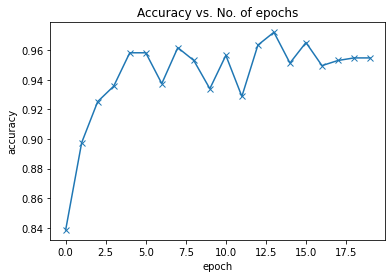

In [19]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

plot_accuracies(history)

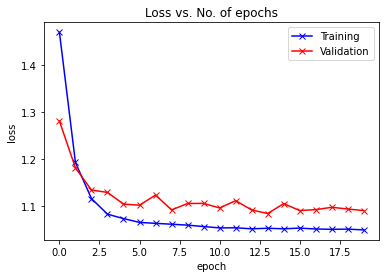

In [20]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

In [21]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    prob, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

Label: metal , Predicted: metal


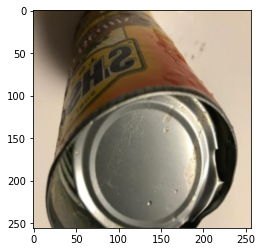

In [22]:
img, label = test_ds[17]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

In [23]:
checkpoint = torch.load('models/RESNET50.pt',map_location=torch.device('cpu'))
model.load_state_dict(checkpoint)
model.eval()

ResNet(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (

In [24]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    prob, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

Label: glass , Predicted: glass


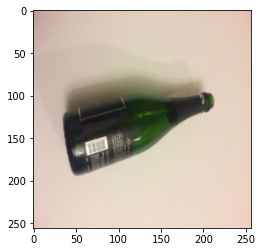

In [25]:
img, label = test_ds[347]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

In [26]:
from PIL import Image
from pathlib import Path

def predict_external_image(image_name):
    image = Image.open(Path('./' + image_name))
    example_image = transformations(image)
    plt.imshow(example_image.permute(1, 2, 0))
    a=predict_image(example_image, model)
    return a
    print("The image resembles",predict_image(example_image, model) + ".")

'metal'

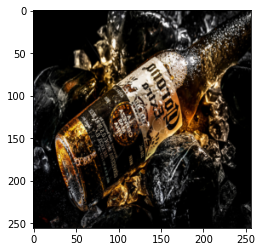

In [27]:
predict_external_image('garbage/glass.jpg')

In [3]:
p=[]
imgList = os.listdir('garbage')
tar_list=imgList[1:]
for img in tar_list:
    name='garbage/'+img
    print(name)
print('预测列表：')
print(['paper', 'plastic', 'plastic', 'cardboard', 'metal'])

garbage/paper.jpg
garbage/plastic.jpg
garbage/mental.jpg
garbage/cardboard.jpg
garbage/glass.jpg
预测列表：
['paper', 'plastic', 'plastic', 'cardboard', 'metal']


In [ ]:

import torch.utils.data.distributed
'定义转化后的模型名称'
model_ori_pt ='RESNET50.pt'
'加载pytorch模型'
model = torch.load('models/RESNET50.pth')
'模型在cpu上运行'
device = torch.device('cpu')
model.to(device)
model.eval()
'定义输入图片的大小'
input_tensor = torch.rand(1, 3, 256, 256)

'转化模型并存储'
mobile_ori = torch.jit.trace(model, input_tensor)
mobile.save(model_ori_pt)